### Uncomment the following blocks in order to install dependencies in Google Colab

In [30]:
 ! git clone https://github.com/stellagerantoni/learning-time-series-counterfactuals
 %cd learning-time-series-counterfactuals/ 

Cloning into 'learning-time-series-counterfactuals'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 147 (delta 82), reused 107 (delta 48), pack-reused 0
Receiving objects: 100% (147/147), 1.45 MiB | 1.65 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/learning-time-series-counterfactuals/src/LIMESegment/Utils/learning-time-series-counterfactuals


In [31]:
!pip install -q -U tensor2tensor
!pip install -q tensorflow matplotlib
!pip install -q wildboar
!pip install -q stumpy
!pip install -q fastdtw

In [32]:
import sys
sys.path.append('./learning-time-series-counterfactuals/src')
sys.path.append('./learning-time-series-counterfactuals/LIMESegment/Utils/')

### Actual codes start

In [33]:
import logging
import os
import warnings
from argparse import ArgumentParser

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                             find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

In [34]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


In [35]:
logger = logging.getLogger(__name__)
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")
RANDOM_STATE = 39

DATASET_NAME = "TwoLeadECG"
OUTPUT_FILENAME = "twolead-outfile.csv"
result_writer = ResultWriter(file_name=OUTPUT_FILENAME, dataset_name=DATASET_NAME)
logger.info(f"Result writer is ready, writing to {OUTPUT_FILENAME}...")
result_writer.write_head()


In [36]:
# 1. Load data
X, y = load_dataset(DATASET_NAME, repository="wildboar/ucr")

pos = 1
neg = 2
# Convert positive and negative labels to 1 and 0
pos_label, neg_label = 1, 0
y_copy = y.copy()
if pos != pos_label:
    y_copy[y==pos] = pos_label # convert/normalize positive label to 1
if neg != neg_label:
    y_copy[y==neg] = neg_label # convert negative label to 0

X_train, X_test, y_train, y_test = train_test_split(X, y_copy, test_size=0.2, random_state=RANDOM_STATE, stratify=y_copy) 

# Upsample the minority class
y_train_copy = y_train.copy()
X_train, y_train = upsample_minority(X_train, y_train, pos_label=pos_label, neg_label=neg_label)
if y_train.shape != y_train_copy.shape:
    logger.info(f"Data upsampling performed, current distribution of y: \n{pd.value_counts(y_train)}.")


In [37]:
# ### 1.1 Normalization - fit scaler using training data 
n_training, n_timesteps = X_train.shape
n_features = 1

X_train_processed, trained_scaler = time_series_normalize(data=X_train, n_timesteps=n_timesteps)
X_test_processed, _ = time_series_normalize(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler)

X_train_processed_padded, padding_size = conditional_pad(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad(X_test_processed) 
n_timesteps_padded = X_train_processed_padded.shape[1]
logger.info(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")


In [38]:
y_train_classes = y_train
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

In [39]:
# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()

###############################################
# ## 2.1 1dCNN autoencoder + 1dCNN classifier
###############################################
# ### 1dCNN autoencoder
autoencoder = Autoencoder(n_timesteps_padded, n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse") 

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
logger.info("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train_processed_padded, 
    X_train_processed_padded, 
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=True, 
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
logger.info(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")

Epoch 1/50
30/30 [==============================] - 4s 49ms/step - loss: 0.1719 - val_loss: 0.0260
Epoch 2/50
30/30 [==============================] - 1s 20ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 3/50
30/30 [==============================] - 1s 27ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 4/50
30/30 [==============================] - 1s 33ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
30/30 [==============================] - 1s 33ms/step - loss: 9.2207e-04 - val_loss: 6.4904e-04
Epoch 7/50
30/30 [==============================] - 1s 35ms/step - loss: 5.2869e-04 - val_loss: 4.1440e-04
Epoch 8/50
30/30 [==============================] - 1s 37ms/step - loss: 3.7388e-04 - val_loss: 3.1025e-04
Epoch 9/50
30/30 [==============================] - 1s 36ms/step - loss: 2.9148e-04 - val_loss: 2.6876e-04
Epoch 10/50
30/30 [==============================] - 1s 35ms/step - loss: 2.5

In [40]:
def Classifier(n_timesteps, n_features, n_output=2, n_conv_layers=1, add_dense_layer=True):
    # https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
    inputs = keras.Input(shape=(n_timesteps, n_features), dtype="float32")
    
    if add_dense_layer:
        x = keras.layers.Dense(128)(inputs)
    else: 
        x = inputs
    
    for i in range(n_conv_layers):
        x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    x = keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
    x = keras.layers.Flatten()(x)

    outputs = keras.layers.Dense(n_output, activation='softmax')(x)
    classifier = keras.Model(inputs, outputs)
    classifier = keras.models.Model(inputs=inputs, outputs=outputs)
    
    return classifier

In [41]:
shallow_cnn = True
# ### 1dCNN classifier
if shallow_cnn == True:
    logger.info(f"Check shallow_cnn argument={shallow_cnn}, use the shallow structure.")
    classifier = Classifier(n_timesteps_padded, n_features, n_conv_layers=1, add_dense_layer=True) # shallow CNN for small data size
else:
    classifier = Classifier(n_timesteps_padded, n_features, n_conv_layers=3, add_dense_layer=False) # deeper CNN layers for data with larger size

optimizer = keras.optimizers.Adam(lr=0.0001)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
# Train the model
reset_seeds()
logger.info("Training log for 1dCNN classifier:")
classifier_history = classifier.fit(X_train_processed_padded, 
        y_train, 
        epochs=150,
        batch_size=32,
        shuffle=True, 
        verbose=True, 
        validation_data=(X_test_processed_padded, y_test),
        callbacks=[early_stopping_accuracy])


Epoch 1/150
30/30 [==============================] - 2s 39ms/step - loss: 0.6109 - accuracy: 0.6957 - val_loss: 0.7348 - val_accuracy: 0.4979
Epoch 2/150
30/30 [==============================] - 1s 24ms/step - loss: 0.4267 - accuracy: 0.9118 - val_loss: 0.8707 - val_accuracy: 0.4979
Epoch 3/150
30/30 [==============================] - 1s 25ms/step - loss: 0.3184 - accuracy: 0.9398 - val_loss: 0.9401 - val_accuracy: 0.4979
Epoch 4/150
30/30 [==============================] - 1s 24ms/step - loss: 0.2255 - accuracy: 0.9774 - val_loss: 0.8957 - val_accuracy: 0.4979
Epoch 5/150
30/30 [==============================] - 1s 24ms/step - loss: 0.1767 - accuracy: 0.9839 - val_loss: 0.9709 - val_accuracy: 0.4979
Epoch 6/150
30/30 [==============================] - 1s 24ms/step - loss: 0.1365 - accuracy: 0.9914 - val_loss: 0.8328 - val_accuracy: 0.5021
Epoch 7/150
30/30 [==============================] - 1s 38ms/step - loss: 0.1101 - accuracy: 0.9903 - val_loss: 0.6245 - val_accuracy: 0.6094
Epoch 

In [42]:
y_pred = classifier.predict(X_test_processed_padded)
# y_pred_classes = np.array([1 if pred > 0.5 else 0 for pred in y_pred])
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
logger.info(f"1dCNN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
confusion_matrix_df

8/8 [==============================] - 0s 7ms/step


,Pred:pos,Pred:neg
True:pos,117,0
True:neg,0,116


## Get LIME local weights

In [43]:
import sys
sys.path.append('../LIMESegment/Utils/')
%cd src/LIMESegment/Utils/

/content/learning-time-series-counterfactuals/src/LIMESegment/Utils/learning-time-series-counterfactuals/src/LIMESegment/Utils


In [44]:
from explanations import LIMESegment

In [45]:
idx = 2 # explained instance
series = X_test_processed_padded[idx]
print(y_pred_classes[idx])

1


In [46]:
"""
# parameters
ts: TS array of shape T x 1 where T is length of time series
model: Trained model on dataset array of shape n x T x 1
model_type: String indicating if classificaton model produces binary output "class" or probability output "proba", default "class"
distance: Distance metric to be used by LIMESegment default is 'dtw'
window_size: Window size to be used by NNSegment default is T/5
cp: Number of change points to be determinded by NNSegment default is 3
f: Frequency parameter for RBP default is T/10
"""

explanations = LIMESegment(series, classifier, model_type='proba', cp=10, window_size=10)
explanations

4/4 [==============================] - 0s 8ms/step


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([-0.0173028 ,  0.48571366, -0.04890356, -0.41467095,  0.07317616,
        -0.1646627 , -0.1737599 ,  0.00528451, -0.02162884,  0.00988812,
        -0.08102037]), [0, 5, 13, 19, 30, 40, 48, 53, 58, 66, 72, -1])

In [47]:
seg_imp, seg_idx = explanations
total_len = len(series)
seg_idx[-1] = total_len

In [48]:
series.shape

(84, 1)

0, 5: -0.017302798814710918
5, 13: 0.48571365887689044
13, 19: -0.04890356206898117
19, 30: -0.4146709526951232
30, 40: 0.07317615798844683
40, 48: -0.16466270358846571
48, 53: -0.17375989852533663
53, 58: 0.005284514653285567
58, 66: -0.021628838089892365
66, 72: 0.009888122441767289
72, 84: -0.08102036634589747


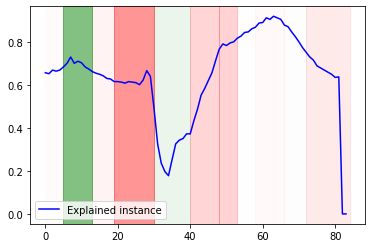

In [49]:
import math

plt.plot(series, color='b', label='Explained instance')
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
plt.legend(loc='lower left')

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i]
    end = seg_idx[i+1] 
    print(f'{start}, {end}: {weight}')
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=abs(weight))
    

In [50]:
check = np.where(seg_imp >= 0.01) # seg_imp >= 0.01 or 0.1
check[0]

array([1, 4])

In [51]:
weighted_steps = np.ones(total_len)

for start_idx in check[0]:
    weighted_steps[seg_idx[start_idx]: seg_idx[start_idx+1]] = 0
weighted_steps

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [52]:
np.where(weighted_steps == 0)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39]),)

### UPDATE: modified LIME segment (TODO, intergrate the updated version in LatentCF)

In [53]:
from scipy import signal
import stumpy
from sklearn.linear_model import Ridge
from sklearn.utils import check_random_state
from fastdtw import fastdtw
import random
from explanations import NNSegment, RBP

def LIMESegment(example, model, model_type='class', distance='dtw', n=100, window_size=None, cp=None, f=None, random_state=None):
    random_state = check_random_state(random_state)
    if window_size is None:
        window_size =int(example.shape[0]/5)
    if cp is None:
        cp = 3
    if f is None: 
        f = int(example.shape[0]/10)
    
    cp_indexes = NNSegment(example.reshape(example.shape[0]), window_size, cp)
    segment_indexes = [0] + cp_indexes + [-1]
    generated_samples_interpretable = [random_state.binomial(1, 0.5, len(cp_indexes)+1) for _ in range(0,n)] #UPDATE HERE
    
    generated_samples_raw = RBP(generated_samples_interpretable, example, segment_indexes, f)
    sample_predictions = model.predict(generated_samples_raw)
    
#     print(np.argmax(sample_predictions, axis=1))

    if model_type == 'proba':
        y_labels = np.argmax(sample_predictions, axis=1)
    elif isinstance(model_type, int): #UPDATE HERE
        y_labels = sample_predictions[:, model_type]
    else:
        y_labels = sample_predictions
    
    if distance == 'dtw':
        distances = np.asarray([fastdtw(example, sample)[0] for sample in generated_samples_raw])
        weights = np.exp(-(np.abs((distances - np.mean(distances))/np.std(distances)).reshape(n,)))
    elif distance == 'euclidean':
        distances = np.asarray([np.linalg.norm(np.ones(len(cp_indexes)+1)-x) for x in generated_samples_interpretable])
        weights = np.exp(-(np.abs(distances**2/0.75*(len(segment_indexes)**2)).reshape(n,)))

    clf = Ridge(random_state=random_state) #UPDATE HERE
    clf.fit(generated_samples_interpretable, y_labels, weights)

    return clf.coef_, segment_indexes


In [54]:
explanations = LIMESegment(series, classifier, model_type=0, random_state=12, cp=10, window_size=10) # warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
explanations

4/4 [==============================] - 0s 7ms/step


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 0.02058312, -0.37443078, -0.01305485,  0.52064166, -0.04373413,
         0.15369393,  0.12898567, -0.16725209, -0.16731821, -0.04623422,
        -0.07549762]), [0, 5, 13, 19, 30, 40, 48, 53, 58, 66, 72, -1])

## CF generation

In [55]:
from _composite import extract_encoder_decoder

In [56]:
class ModifiedLatentCF:
    """Explanations by generating a counterfacutal sample in the latent space of
    any autoencoder.

    References
    ----------
    Latent-CF: A Simple Baseline for Reverse Counterfactual Explanation
        Rachana Balasubramanian and Samuel Sharpe and Brian Barr and Jason Wittenbach and C. Bayan Brus
        In Proceedings of the Conference on Neural Information Processing Systems, 2020
    """

    def __init__(    
        self, 
        probability=0.5, 
        *, 
        alpha=0.001, 
        tolerance=1e-6, 
        learning_rate=1e-3, 
        max_iter=100,
        optimizer=None,
        autoencoder=None,
        only_encoder=None,
        only_decoder=None,
        validity_loss_weight=1.0
    ):
        """
        Parameters
        ----------
        probability : float, optional
            The desired probability assigned by the model

        alpha : float, optional
            The step size

        tolerance : float, optional
            The maximum difference between the desired and assigned probability

        learning_rate : float, optional
            The learning rate of the optimizer

        max_iter : int, optional
            The maximum number of iterations

        autoencoder : int, optional
            The autoencoder for the latent representation

            - if None the sample is generated in the original space
            - if given, the autoencoder is expected to have `k` decoder layer and `k`
              encoding layers.
        """
        self.optimizer_ = tf.optimizers.Adam(learning_rate=1e-4) if optimizer is None else optimizer
        self.mse_loss_ = keras.losses.MeanSquaredError() 
#         self.mae_loss_ = keras.losses.MeanAbsoluteError() 
        self.alpha_ = tf.constant(alpha)
        self.probability_ = tf.constant(probability)
        self.tolerance_ = tf.constant(tolerance)
        self.max_iter = max_iter
        self.autoencoder = autoencoder
        self.only_encoder = only_encoder
        self.only_decoder = only_decoder
        
        # Weights of the different loss components
        self.validity_weight = validity_loss_weight
        self.proximity_weight = (1 - self.validity_weight)

    def fit(self, model):
        """Fit a new counterfactual explainer to the model

        Paramaters
        ----------

        model : keras.Model
            The model
        """
        if self.autoencoder:
            encode_input, encode_output, decode_input, decode_output = extract_encoder_decoder(self.autoencoder)
            self.decoder_ = keras.Model(inputs=decode_input, outputs=decode_output)
            self.encoder_ = keras.Model(inputs=encode_input, outputs=encode_output)
        elif self.only_encoder and self.only_decoder:
            self.encoder_ = self.only_encoder
            self.decoder_ = self.only_decoder
        else:
            self.decoder_ = None
            self.encoder_ = None
        self.model_ = model
        return self

    def predict(self, x):
        """Compute the differnece beteween the desired and actual probability

        Paramters
        ---------
        x : Variable
            Variable of the sample
        """
        if self.autoencoder is None:
            z = x
        else:
            z = self.decoder_(x)
        
        return self.model_(z)
    
    # TODO: add global weights in the function input?
    def get_local_weights(self, input_sample):
        local_explanation = LIMESegment(input_sample, self.model_, model_type='proba', cp=10, window_size=10)
        
        check = np.where(seg_imp <= -0.01) # TODO: decide the threshold, 0.01 or 0.1? seg_imp >= threshold or or <= -threshold???
        weighted_steps = np.ones(total_len) # if weights are all one? => same as a normal MAE function
        for start_idx in check[0]:
            weighted_steps[seg_idx[start_idx]: seg_idx[start_idx+1]] = 0
        
        weighted_steps = weighted_steps.reshape(1, n_timesteps_padded, 1) # need to reshape for multiplication in `tf.math.multiply()`
        return weighted_steps
    

    # The "validity_loss" is designed to measure the prediction probability to the desired decision boundary
    def validity_loss(self, prediction):
        return self.mse_loss_(self.probability_, prediction) 
    
    # An auxiliary MAE loss function to measure the proximity with step_weights
    def weighted_mean_absolute_error(self, original_sample, cf_sample, step_weights):
        return tf.math.reduce_mean(
            tf.math.multiply(tf.math.abs(original_sample - cf_sample), step_weights)
        )
    
    def compute_loss(self, original_sample, z_search, step_weights): # additional input of step_weights
        # Initialize the loss
        loss = tf.zeros(shape=())
        decoded = self.decoder_(z_search)
        pred = self.model_(decoded)
        
        # Add validity_loss 
        valid_loss = self.validity_loss(pred)
        loss += self.validity_weight * valid_loss

        # Add proximity_loss
        proxi_loss = self.weighted_mean_absolute_error(
            original_sample, decoded, step_weights=tf.cast(step_weights, tf.float32)) 
        loss += self.proximity_weight * proxi_loss

        return loss, valid_loss, proxi_loss

    # TODO: compatible with the counterfactuals of wildboar
    #       i.e., define the desired output target per label
    def transform(self, x):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """
        if self.only_encoder is not None: # if only encoder, then return the latent embeddings
            _, encoded_dim1, encoded_dim2 = self.only_encoder.layers[-1].output_shape
            result_samples = np.empty((x.shape[0], encoded_dim1, encoded_dim2)) 
        else: 
            result_samples = np.empty(x.shape)

        losses = np.empty(x.shape[0])
        for i in range(x.shape[0]):
            if i % 50 == 0: print(f'{i} samples been transformed.')
            
            step_weights = self.get_local_weights(x[i])
            x_sample, loss = self._transform_sample_z(x[np.newaxis, i], step_weights)

            result_samples[i] = x_sample
            losses[i] = loss

        return result_samples, losses

    def _transform_sample_z(self, x, step_weights):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """
        # TODO: check_is_fitted(self)
        if self.only_encoder or self.autoencoder is not None:
            z = tf.Variable(self.encoder_(x))
        else:
            z = tf.Variable(x, dtype=tf.float32)

        it = 0
        with tf.GradientTape() as tape:
            loss, valid_loss, proxi_loss = self.compute_loss(x, z, step_weights)
            
        pred = self.model_(self.decoder_(z))
        
        # TODO: modify the loss to check both validity and proximity; how to design the condition here?
        # while (valid_loss > self.tolerance_ or pred[:, 1] < self.probability_ or proxi_loss > 0.001)
        while (valid_loss > self.tolerance_ or pred[:, 1] < self.probability_ ) and \
        (it < self.max_iter if self.max_iter else True):
            # Get gradients of loss wrt the sample
            grads = tape.gradient(loss, z)
            # Update the weights of the sample
            self.optimizer_.apply_gradients([(grads, z)])
            
            with tf.GradientTape() as tape:
                loss, valid_loss, proxi_loss = self.compute_loss(x, z, step_weights)
            it += 1
            pred = self.model_(self.decoder_(z))
        
        pred = self.model_(self.decoder_(z))
        print(f'current valid: {valid_loss}, proxi: {proxi_loss}, pred prob:{pred}, iter: {it}.')
  
        return z.numpy() if self.autoencoder is None else self.decoder_(z).numpy(), float(loss)

In [57]:
## Evaluation metrics
# use radius to find the count of points - KDTree; a trained tree is needed for evaluation
tree = KDTree(
    X_train_processed[y_train_classes==pos_label].reshape(-1, n_timesteps), 
    leaf_size=40, metric='euclidean')
max_distance = distance_matrix(
    X_train_processed[y_train_classes==neg_label].reshape(-1, n_timesteps), 
    X_train_processed[y_train_classes==pos_label].reshape(-1, n_timesteps)).max()


### loss weight: 0.01 valid + 0.99 proxi


In [63]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.5, autoencoder=autoencoder, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
    validity_loss_weight=0.01)

cf_model.fit(classifier)


In [ ]:
y_pred = classifier.predict(X_test_processed_padded[y_pred_classes == 0]) 
# y_pred

X_pred_neg = X_test_processed_padded[y_pred_classes == 0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses = cf_model.transform(X_pred_neg)


4/4 [==============================] - 0s 13ms/step
0 samples been transformed.
4/4 [==============================] - 0s 8ms/step
current valid: 0.25, proxi: 0.001699176267720759, pred prob:[[1.000000e+00 2.094302e-10]], iter: 100.
4/4 [==============================] - 0s 7ms/step
current valid: 3.3658707820904965e-08, proxi: 0.0014217367861419916, pred prob:[[0.49981654 0.50018346]], iter: 68.
4/4 [==============================] - 0s 7ms/step
current valid: 4.371779311895807e-07, proxi: 0.0013067370746284723, pred prob:[[0.4993388 0.5006612]], iter: 92.
4/4 [==============================] - 0s 14ms/step
current valid: 0.25, proxi: 0.0002844009140972048, pred prob:[[1.000000e+00 6.972483e-10]], iter: 100.
4/4 [==============================] - 0s 7ms/step
current valid: 1.4819846910540946e-05, proxi: 0.0007172743207775056, pred prob:[[0.4961503 0.5038496]], iter: 100.
4/4 [==============================] - 0s 7ms/step


In [ ]:
z_pred = classifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
if padding_size != 0: # remove extra paddings after counterfactual generation
    best_cf_samples = cf_embeddings[:, :-padding_size, :] 
    X_pred_neg = X_test_processed[y_pred_classes == neg_label] # use the unpadded X for evaluation

evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
evaluate_res #  proximity, validity, cost_mean, cost_std


In [ ]:
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

plt.figure(figsize=(16, 16))
for i in range(1, 5): # plot first 4 samples
    ax = plt.subplot(3, 2, i)
    idx = i-1 # the actual index of the sample is i-1
    ax.set_title("prob(z) = %.2f, prob(x)=%.2f" % (z_pred[idx], y_pred[:, 1][idx]))
    ax.plot(actual_Xs[idx].reshape(-1), c="b")
    ax.plot(actual_cfs[idx].reshape(-1), c="r")
plt.show()

### loss weight: 0.25 valid + 0.75 proxi


In [ ]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.5, autoencoder=autoencoder, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
    validity_loss_weight=0.25)

cf_model.fit(classifier)


In [ ]:
y_pred = classifier.predict(X_test_processed_padded[y_pred_classes == 0]) 
# y_pred

X_pred_neg = X_test_processed_padded[y_pred_classes == 0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses = cf_model.transform(X_pred_neg)


In [ ]:
z_pred = classifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
if padding_size != 0: # remove extra paddings after counterfactual generation
    best_cf_samples = cf_embeddings[:, :-padding_size, :] 
    X_pred_neg = X_test_processed[y_pred_classes == neg_label] # use the unpadded X for evaluation

evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
evaluate_res #  proximity, validity, cost_mean, cost_std


In [ ]:
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

plt.figure(figsize=(16, 16))
for i in range(1, 5): # plot first 4 samples
    ax = plt.subplot(3, 2, i)
    idx = i-1 # the actual index of the sample is i-1
    ax.set_title("prob(z) = %.2f, prob(x)=%.2f" % (z_pred[idx], y_pred[:, 1][idx]))
    ax.plot(actual_Xs[idx].reshape(-1), c="b")
    ax.plot(actual_cfs[idx].reshape(-1), c="r")
plt.show()

### loss weight: 0.5 valid + 0.5 proxi

In [ ]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.5, autoencoder=autoencoder, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
    validity_loss_weight=0.5)

cf_model.fit(classifier)


In [ ]:
y_pred = classifier.predict(X_test_processed_padded[y_pred_classes == 0]) 
# y_pred

X_pred_neg = X_test_processed_padded[y_pred_classes == 0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses = cf_model.transform(X_pred_neg)


In [ ]:
z_pred = classifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
if padding_size != 0: # remove extra paddings after counterfactual generation
    best_cf_samples = cf_embeddings[:, :-padding_size, :] 
    X_pred_neg = X_test_processed[y_pred_classes == neg_label] # use the unpadded X for evaluation

evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
evaluate_res #  proximity, validity, cost_mean, cost_std


In [ ]:
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

plt.figure(figsize=(16, 16))
for i in range(1, 5): # plot first 4 samples
    ax = plt.subplot(3, 2, i)
    idx = i-1 # the actual index of the sample is i-1
    ax.set_title("prob(z) = %.2f, prob(x)=%.2f" % (z_pred[idx], y_pred[:, 1][idx]))
    ax.plot(actual_Xs[idx].reshape(-1), c="b")
    ax.plot(actual_cfs[idx].reshape(-1), c="r")
plt.show()

### loss weight: 0.75 valid + 0.25 proxi

In [ ]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.5, autoencoder=autoencoder, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
    validity_loss_weight=0.75)

cf_model.fit(classifier)  

In [ ]:
y_pred = classifier.predict(X_test_processed_padded[y_pred_classes == 0]) 
# y_pred

X_pred_neg = X_test_processed_padded[y_pred_classes == 0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses = cf_model.transform(X_pred_neg)


In [ ]:
z_pred = classifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
if padding_size != 0: # remove extra paddings after counterfactual generation
    best_cf_samples = cf_embeddings[:, :-padding_size, :] 
    X_pred_neg = X_test_processed[y_pred_classes == neg_label] # use the unpadded X for evaluation

evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
evaluate_res #  proximity, validity, cost_mean, cost_std


In [ ]:
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

plt.figure(figsize=(16, 16))
for i in range(1, 5): # plot first 4 samples
    ax = plt.subplot(3, 2, i)
    idx = i-1 # the actual index of the sample is i-1
    ax.set_title("prob(z) = %.2f, prob(x)=%.2f" % (z_pred[idx], y_pred[:, 1][idx]))
    ax.plot(actual_Xs[idx].reshape(-1), c="b")
    ax.plot(actual_cfs[idx].reshape(-1), c="r")
plt.show()

### loss weight: 1 valid + 0 proxi

In [ ]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.5, autoencoder=autoencoder, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
    validity_loss_weight=1.0)

cf_model.fit(classifier)

In [ ]:
y_pred = classifier.predict(X_test_processed_padded[y_pred_classes == 0]) 
# y_pred

X_pred_neg = X_test_processed_padded[y_pred_classes == 0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses = cf_model.transform(X_pred_neg)


In [ ]:
z_pred = classifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
if padding_size != 0: # remove extra paddings after counterfactual generation
    best_cf_samples = cf_embeddings[:, :-padding_size, :] 
    X_pred_neg = X_test_processed[y_pred_classes == neg_label] # use the unpadded X for evaluation

evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
evaluate_res #  proximity, validity, cost_mean, cost_std


In [ ]:
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

plt.figure(figsize=(16, 16))
for i in range(1, 5): # plot first 4 samples
    ax = plt.subplot(3, 2, i)
    idx = i-1 # the actual index of the sample is i-1
    ax.set_title("prob(z) = %.2f, prob(x)=%.2f" % (z_pred[idx], y_pred[:, 1][idx]))
    ax.plot(actual_Xs[idx].reshape(-1), c="b")
    ax.plot(actual_cfs[idx].reshape(-1), c="r")
plt.show()